# Optimal Public Expenditure

This notebook computes the optimal level of public expenditure in a simple matching model of the business cycle.

The model features self-employed workers who sell their services on a matching market to other households and the government.

The notebook calibrates the model to US data. The notebook simulates the model in response to aggregate-demand shocks and aggregate-supply shocks.

The notebook then computes the optimal stimulus spending in response to these shocks.

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Applying the Model to U.S Data

To calculate optimal stimulus spending, we need to calibrate parameters in equation (23) in [Michaillat and Saez (2019)](https://www.pascalmichaillat.org/6.html), which says:

$$\frac{g/c - (g/c)^*}{(g/c)^*} \approx \frac{z_0 \epsilon m}{1 + z_1 z_0\epsilon m^2}\cdot \frac{u_0 - u^*}{u^*},  $$

where 

$$ m = \frac{(1-u)\cdot M}{1- \frac{G}{Y}\cdot \frac{\eta}{1-\eta}\cdot \frac{\tau}{u}\cdot M},$$

$$ z_0 = \frac{1}{(1-\eta)(1-u^*)^2},$$

and 

$$z_1 = \frac{(g/y)^* (c/y)^*}{u^*}.$$

### Fetching Data

First, we  will fetch data series for macroeconomic variables from FRED. The data series we need are `unemployment`, `public expenditure`, and `output`.

To do this, we will use the `fredapi` package. 

In [3]:
from fredapi import Fred
fred = Fred(api_key='30adf5295a539a48e57fe367896a60e9')

We can now grab the series we want:

In [9]:
df = {}
df['u'] = fred.get_series('UNRATE', frequency='q')
df['Y'] = fred.get_series('GDP', frequency='q')
df['G'] = fred.get_series('W068RCQ027SBEA', frequency='q')
df['C'] = fred.get_series('PCE', frequency='q')
df = pd.DataFrame(df)
df.dropna(inplace=True)

Below is the trend for unemployment

<AxesSubplot:>

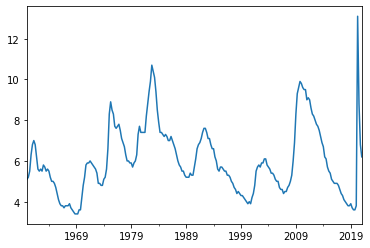

In [32]:
df['u'].plot()

Here are the trends for output, government spending, and consumption

<AxesSubplot:>

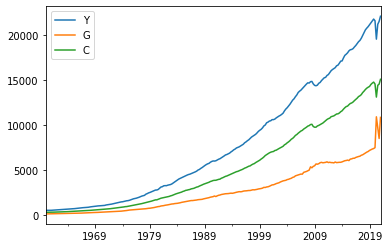

In [33]:
df[['Y', 'G', 'C']].plot()

### Calibration

Now, we can calculate the different ratios we need in our calibration

In [15]:
df['G/C'] = df['G']/df['C']
df['G/Y'] = df['G']/df['Y']
df['C/Y'] = 1 - df['G/Y']

Here are what the calculated ratios look like:

<AxesSubplot:>

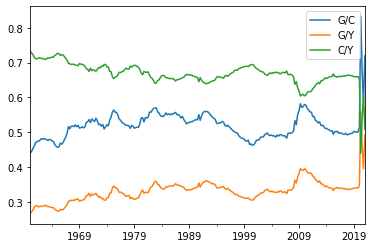

In [34]:
df[['G/C', 'G/Y', 'C/Y']].plot()

Amano and Wirjanto (1997, 1998) estimate the elasticity of substitution between public and private consumption to be 0.9 and 1.56. Here, we consider three values: $\epsilon = 0.5, \epsilon = 1$ and $\epsilon = 1.5.$ 

In [ ]:
epsilon = [0.5, 1, 1.5]

Now, we want to estimate the theoretical unemployment multiplier $m$. For $\eta$, we follow Landais et al. (2018a) and pick $\eta = 0.6$.  For the empirical unemployment multiplier $M$, we follow a strand of literature and compute optimal stimulus spending for a range of unemployment multipliers: $0<M<2$. 

In [30]:
eta = 0.6
Ms = np.linspace(start=0, stop=2, num=101)

We can now calculate the theoretical unemployment multipier

$$ m = \frac{(1-u)\cdot M}{1- \frac{G}{Y}\cdot \frac{\eta}{1-\eta}\cdot \frac{\tau}{u}\cdot M},$$

In [31]:
# To-Do: implement calculation of tau for all time periods
tau = 1.7
ms = [1 - df['u']* M/(1-df['G/Y']*eta/(1 - eta)*tau/df['u']*M) for M in Ms]

Recall

$$ z_0 = \frac{1}{(1-\eta)(1-u^*)^2},$$

and 

$$z_1 = \frac{(g/y)^* (c/y)^*}{u^*}.$$

We can now calculate $z_0$ and $z_1$ for any point in time.

In [25]:
df['z0'] = 1/((1 - eta)*(1 - df['u'])**2)
df['z1'] = df['G/Y']*df['C/Y']/df['u']

### Calculating Optimal Stimulus

## Simulations 

We first calibrate the following parameters that will be used in the model:
- $k$ : productive capacity, which can also be endogenized by adding a labor market where firms hire workers
- $\epsilon$ : elasticity of substitution between public and private consumption
- $\eta$ : matching elasticity
- $s$ : job-separation rate
- $\omega$ : matching efficiency
- $\bar{u}$ : target for average unemployment
- $\bar{x}$ : target for average tightness
- $\bar{Y}$ : target for average output
- $\bar{M}$ : target for average output multiplier (same as unemployment multiplier)
- $\bar{G/C}$ : target for average G/C
- $\gamma$ : preference parameter

The calibration values below are based on US data.

In [2]:
k = 1 # normalization
epsilon = 1 
eta = 0.6
s = 0.028 
omega = 0.60 
ubar = 0.061
xbar = 0.43
Ybar = k*(1 - ubar)
Mbar = 0.5 
GCbar = 0.197 
gamma = 1/(1 + 1/GCbar) 

For convenience, we will define a few functions to calculate key macroeconomic variables:

In [23]:
GY = lambda gc:gc/(1 + gc) # G/Y
CY = lambda gc:1 - GY(gc)  # C/Y
GC = lambda GY:GY/(1 - GY) # G/C
u = lambda x:s/(s + f(x))  # unemployment rate
Y = lambda x:(1 - u(x))*k  # output

We will then use these functions to calculate target macroeconomic variables as well as the price rigidity $r$ that matches multiplier target :

In [ ]:
GYbar = GY(GCbar)
CYbar = CY(GCbar)
Gbar = GYbar*Ybar
Cbar = CYbar*Ybar
r = (Mbar*epsilon*CYbar)/(1 - Mbar*GYbar)

We also compute the following matching parameters. 

The buying rate $q$, as a function of labor market tightness $x$, is:

$$q(x) = \omega x^{\eta}.$$

The selling rate $f$, as a function of labor market tightness $x$, is:

$$f(x) = \omega x^{1-\eta}.$$

In [ ]:
q = lambda x:omega*x**(-eta) #buying rate
f = lambda x:omega*x**(1 - eta) #selling rate

The average matching wedge $\bar{\tau}$ is:

$$\bar{\tau} = (1-\eta)\frac{\bar{u}}{\eta}.$$

The matching cost $\rho$ is given by:

$$\rho = q(\bar{x})\frac{\bar{\tau}}{1+\bar{\tau}}.$$

The matching wedge $\tau$ is:

$$\tau(x) = s\frac{\rho}{q(x) - s\rho}.$$

The formula for elasticity of output to tightness is given by 

$$\frac{d\ln{y}}{d\ln{x}} = (1-\eta) * u(x) - \eta * \tau(x).$$

In [ ]:
taubar = (1-eta)*ubar/eta #average matching wedge
rho = q(xbar)/s*taubar/(1 + taubar) #matching cost
tau = lambda x:s*rho/(q(x) - s*rho) #matching wedge
dlnydlnx = lambda x:(1-eta)*u(x) - eta*tau(x) #elasticity of output to tightness

### Utility Function

Given the elasticity of substitution between private and public consumption $\epsilon$, we have the following CES utility function:

When $\epsilon = 1$, the utility function is Cobb-Douglas:

$$\mathcal{U}(c,g) = \frac{c^{1-\gamma}*g^{\gamma}}{(1-\gamma)^{1-\gamma}*\gamma^\gamma}$$

Otherwise, the utility function is:

$$\mathcal{U}(c, g) = \left((1-\gamma)^{1/\epsilon}*c^{(\epsilon-1)/\epsilon} + \gamma ^{1/\epsilon}*g^{(\epsilon - 1)/\epsilon}\right)^{\epsilon/(\epsilon - 1)}$$


In [52]:
if epsilon == 1:
    scalar = (1 - gamma)**(1 - gamma)*gamma**gamma
    U = lambda c, g:c**(1 - gamma)*g**(gamma)/scalar
else:
	U = lambda c, g:((1 - gamma)**(1/epsilon)*c**((epsilon - 1)/epsilon) + 
                     gamma**(1/epsilon)*g**((epsilon - 1)/epsilon))**(epsilon/(epsilon - 1))

With the given utility function, we have the following first derivatives:

$$\frac{\delta \ln{\mathcal{U}}}{\delta \ln{c}} = (1-\gamma)^{{1/\epsilon}} \left(\frac{c}{\mathcal{U}}\right)^{\frac{\epsilon-1}{\epsilon}},\quad \mathcal{U}_c \equiv \frac{\delta \mathcal{U}}{\delta c} = \left((1-\gamma) \frac{\mathcal{U}}{c}\right)^{1/\epsilon}$$

$$\frac{\delta \ln{\mathcal{U}}}{\delta \ln{g}} = \gamma^{{1/\epsilon}} \left(\frac{g}{\mathcal{U}}\right)^{\frac{\epsilon-1}{\epsilon}},\quad \mathcal{U}_g \equiv \frac{\delta \mathcal{U}}{\delta g} = \left(\gamma \frac{\mathcal{U}}{g}\right)^{1/\epsilon}$$


which gives the marginal rate of substitution:

$$MRS_{gc} = \frac{\mathcal{U}_g}{\mathcal{U}_c}  = \frac{\gamma^{1/\epsilon}}{(1-\gamma)^{1/\epsilon}}*(gc)^{1/\epsilon}.$$

We also have the following second derivatives:

$$
\frac{\delta \ln{\mathcal{U}_c}}{\delta \ln{c}} = \frac{1}{\epsilon}\left(\frac{\delta \mathcal{U}}{\delta c} -1 \right),$$
$$\frac{\delta \ln{\mathcal{U}_c}}{\delta \ln{g}} = \frac{1}{\epsilon}\left(\frac{\delta \mathcal{U}}{\delta g} \right)
$$


In [ ]:
dUdc = lambda gc:((1-gamma)*U(1,gc))**(1/epsilon)
dUdcbar = dUdc(GCbar)
dUdg = lambda gc:(gamma*U(1/gc, 1))**(1/epsilon)
MRS = lambda gc:gamma**(1/epsilon)/(1-gamma)**(1/epsilon)*gc**(1/epsilon)
dlnUdlnc = lambda gc:(1 - gamma)**(1/epsilon)*(U(1, gc))**((1 - epsilon)/epsilon)
dlnUdlng = lambda gc:gamma**(1/epsilon)*(U(1/gc, 1))**((1 - epsilon)/epsilon)
dlnUcdlnc = lambda gc:(dlnUdlnc(gc) - 1)/epsilon
dlnUcdlng = lambda gc:dlnUdlng(gc)/epsilon

### Unemployment Multipliers

Then, we move on to compute the theoretical unemployment multiplier and the output multiplier. The full derivation can be found in `online appendix A`. 

First, we want to compute the effect of public consumption on the price of services, which requires us to look at the price mechanism. It is rigid since it does not respond to demand shocks, and is an expression for the multiplier:

$$p(G) = p_0 \left\{ (1-\gamma) + \gamma ^{\frac{1}{\epsilon}}\left[(1-\gamma)\frac{g}{y^*-g}\right]^{\frac{\epsilon-1}{\epsilon}}\right \}^\frac{1-r}{\epsilon - 1},$$

which gives us:

$$\frac{d\ln{p}}{d\ln{g}} = (1-r) \left[ \frac{\delta\ln{\mathcal{U}_c}}{\delta \ln{g}} - \frac{G}{y^* - G} \frac{\delta\ln{\mathcal{U}_c}}{\delta \ln{c}}  \right] $$

In [ ]:
# initial price level
p0 = dUdcbar**r/(1 + taubar) 
p = lambda G:p0*dUdc(G/(Ybar-G))**(1 - r)
dlnpdlng = lambda G:(1 - r)*(dlnUcdlng(G/(Ybar - G)) - dlnUcdlnc(G/(Ybar - G))*(G/(Ybar - G)))

Then we want to compute the effects of public consumption and tightness on private demand, which are:

$$
\frac{\delta\ln{c}}{\delta \ln{x}} = \frac{\eta \tau(x)}{\delta \ln{\mathcal{U}_c}/\delta\ln(c)}$$
$$\frac{\delta\ln{g}}{\delta \ln{x}} = \frac{\delta \ln{p}/\delta\ln(g) - \delta \ln{\mathcal{U}_c}/\delta\ln(g)}{\delta \ln{\mathcal{U}_c}/\delta\ln(c)}$$

In [ ]:
dlncdlnx = lambda G, x:eta*tau(x)/dlnUcdlnc(G/(Y(x)-G))
dlncdlng = lambda G, x:(dlnpdlng(G)-dlnUcdlng(G/(Y(x)-G)))/dlnUcdlnc(G/(Y(x)-G))

We can also determine the effect of public consumption on equilibrium tightness, which is:

$$\frac{\delta\ln{x}}{\delta \ln{g}} = \frac{(g/y) + (c/y)\delta\ln{c}/\delta\ln{g}}{\delta\ln{y}/\delta\ln{x} - (c/y)\delta\ln{c}/\delta\ln{x}}$$

In [65]:
# Remember to call code library

dlnxdlng = lambda G, x:(G/Y(x) + (1 - G/Y(x))*dlncdlng(G, x))/(dlnydlnx(x) - (1-G/Y(x))*dlncdlnx(G, x))

SyntaxError: invalid syntax (<ipython-input-65-9ec699970a07>, line 1)

Thus, we can compute the theoretical unemployment multiplier

$$m = (1-\eta) (1-u) u \frac{y}{g}\frac{d\ln{x}}{d\ln{g}},$$

and the empirical unemployment multiplier

$$M = \frac{m}{1- u + \frac{g}{y}\frac{\eta}{1-\eta}\frac{\tau}{u}m}.$$

In [ ]:
m = lambda G, x:(1 - eta)*u(x)*(1 - u(x))*dlnxdlng(G, x)*Y(x)/G 
M = lambda G, x:m(G, x)/(1 - u(x) + G/Y(x)*eta*tau(x)/(1 - eta)/u(x)*m(G, x))

### Simulations

We will now run simulations under different shocks. To determine equilibrium under different aggregate demand/government spending, we need to find where AD and AS intersect, which happens when 

$$\frac{dU}{dc} - G = (1+\tau)\frac{p(G)}{\alpha}$$

In [ ]:
# gap between aggregate supply & aggregate demand
findeq = lambda G, x, alpha:abs(dUdc(G/(Y(x) - G)) - ((1 + tau(x))*p(G)/alpha))

We will now run business cycle simulations under aggregate demand shocks, fixing the public expenditure policy at $G/Y = 16.5\%$. For each magnitude of aggregate demand, we find the equilibrium labor market tightness using grid search. 

In [31]:
# Range of aggregate demand
ALPHA = np.arange(start=0.97, step=0.0025, stop=1.03) 
# Grid to search for equilibrium tightness x
x0 = np.arange(start=0.001, step=0.0002, stop=2) 
xad, Gad = np.empty(len(ALPHA)), np.empty(len(ALPHA))
G0 = GYbar*Y(x0)	# G such that G/Y=16.5%
for i, alpha in enumerate(ALPHA):
    eva = findeq(G0, x0, alpha)
    # Finding where AS = AD
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xad[i] = x0[ind]
    Gad[i] = G0[ind]

We then compute all other equilibrium variables with $G/Y = 16.5\%$ under the aggregate demand shocks. 

In [54]:
Yad = Y(xad) # output
GYad = Gad/Yad # G/Y
uad = u(xad) # unemployment rate
Mad = M(Gad, xad) # output multiplier

We then run business-cycle simulations under public spending shocks. We compute equilibrium variables for a range of public spending to output ratios $G/Y$.

In [43]:
# Range of public expenditure G/Y
GY0 = np.arange(start=0.1, step=0.00005, stop=0.25) 
xgy, Ggy = np.empty(len(GY0)), np.empty(len(GY0))
for i, gy in enumerate(GY0):
    # Find G such that G/Y=gy
    G0 = gy*Y(x0)
    eva = findeq(G0, x0, 1)
    ind = np.argmin(eva)
    # Record equlibrium tightness and public expenditure
    xgy[i]=x0[ind]
    Ggy[i]=G0[ind]

And we compute all other macro variables of interest:

In [44]:
Ygy = Y(xgy)      # output
GYgy = Ggy/Ygy    # G/Y
ugy = u(xgy)      # unemployment rate
Mgy = M(Ggy, xgy) # output multiplier

Let's first look at equilibria under aggregate demand shocks:

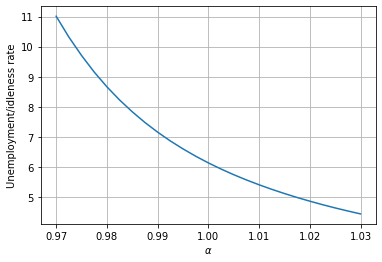

In [67]:
# Unemployment
fig, ax = plt.subplots()
ax.plot(ALPHA, uad*100)
ax.set(xlabel=r'$\alpha$', ylabel='Unemployment/idleness rate')
ax.grid()
plt.show()

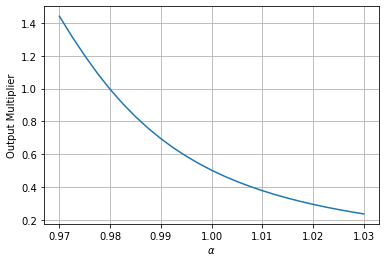

In [56]:
# Output multiplier
fig, ax = plt.subplots()
ax.plot(ALPHA, Mad)
ax.set(xlabel=r'$\alpha$', ylabel='Output multiplier (dY/dG)')
ax.grid()
plt.show()

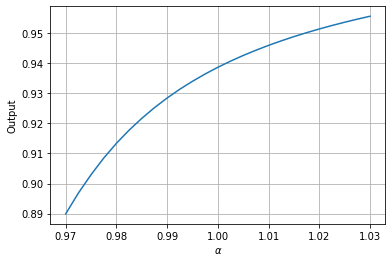

In [57]:
# Output 
fig, ax = plt.subplots()
ax.plot(ALPHA, Yad)
ax.set(xlabel=r'$\alpha$', ylabel='Output = measured productivity')
ax.grid()
plt.show()

We will then examine equilibria under different government spending:

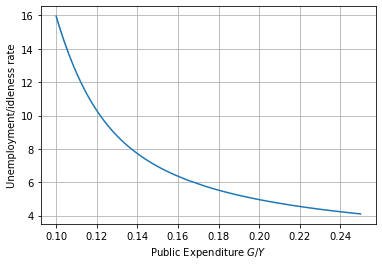

In [60]:
# Unemployment Rate
fig, ax = plt.subplots()
ax.plot(GY0, ugy*100)
ax.set(xlabel=r'Public Expenditure $G/Y$', ylabel='Unemployment/idleness rate')
ax.grid()
plt.show()

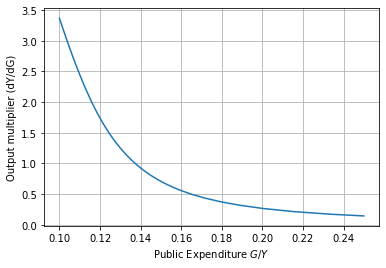

In [61]:
# Output Multiplier
fig, ax = plt.subplots()
ax.plot(GY0, Mgy)
ax.set(xlabel=r'Public Expenditure $G/Y$', ylabel='Output multiplier (dY/dG)')
ax.grid()
plt.show()

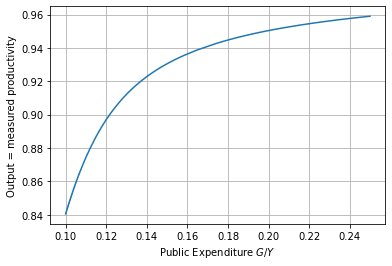

In [62]:
# Unemployment Rate
fig, ax = plt.subplots()
ax.plot(GY0, Ygy)
ax.set(xlabel=r'Public Expenditure $G/Y$', ylabel='Output = measured productivity')
ax.grid()
plt.show()